<a id = 'contents'></a>
# Analysis of the Impact of COVID-19 on Water consumptions Patterns exploiting  Machine Learning techniques

## Table of contents

1. [Introduction and purposes](#intro)


2. [Working dataframe](#df)


3. [Exploratory analysis](#exp)

    - [Overall behaviour](#over)
       
    - [Monthly behaviour](#month)
    
    - [Daily water consuption patterns](#day)
    
    - [Fixtures analysis](#fix)
    
    
4. [A supervised learning problem: classification](#class)

    -  [Preprocessing](#pre)
    
        - [New working dataframe](#new)
        
        - [Pipeline](#pip)
        
    - [SVM Classifier](#svm)
    
        - [Why SVM?](#why)
        
        - [Tuning](#tun)
        
        - [Ensemble learning: bagging](#bag)
        
    - [Real case application](#real)
    
    
5. [Conclusions](#end)

<a id = 'intro'></a>
# Introduction and purposes

The goal, firstly, is to **Explore** the data for capture and analyse the Impact of COVID-19 on water consumptions Patterns.

Then, by also exploiting exploratory results, develop **Machine learning techinques** for solve different tasks.

**WEUSEDTO** dataset contains data about **water consumption** gathered in a residential apartment with one inhabitant sited in Naples, Italy.

Includes **17 months** of water consumption measurements before and within COVID-19: **8 months** from **March** to **October 2019** and **9 months** from **July 2020** and **May 2021**.
 
The introducion of smart working allowed to compare two different profiles: **worker** and **smart worker** user. I will use this profiles as benchmarks for the analysis.
    
Due to the different water consumption impact of the apartment fixtures, I decide to consider only the 4 with greater impact on behavioral routine: **bidet**, **washbasin**, **kitchen faucet** and **shower**.


[Return to contents](#contents)

<a id = 'df'></a>
# Working dataframe 
    
All about on how I import data, libraries and folder path definitions are in the following two notebooks. 
    
[Setup notebook](Setup.ipynb)

[Import notebook](Import.ipynb)

Raw data from github: [Raw data WEUSEDTO](https://github.com/AnnaDiMauro/WEUSEDTO-Data/tree/main/Dataset)


In [2]:
%run setup.ipynb 
%run import.ipynb

In [3]:
df.head()

,Flow,Fixture
Time,,
2019-02-16 16:36:19,92.0,Bidet
2019-02-16 16:36:20,6.0,Bidet
2019-02-16 16:51:52,38.0,Bidet
2019-02-16 16:51:54,58.0,Bidet
2019-02-16 16:51:55,56.0,Bidet


Each row corresponds to a **water consuption measuraments**.

The index **Time** contains `datetime` i.e., **YYYY-MM-DD HH:MM:SS** of each measurement.

**Flow** (ml/s) of the water measurament.

**Fixture** that characterizes each measurament.

The `dataframe` does not cover all the months of the years thus I take two reference periods for my analysis:

- **Pre-covid**: july to october 2019.


- **Intra-covid**: july to october 2020.


# PLESE NOTE :
I associate the profiles: **worker** to the **Pre-covid measurements 2019** while **smart worker** to the **Intra-covid measurements 2020**.

In [4]:
df = pd.concat([df.loc['2019-07':'2019-10'], df.loc['2020-07':'2020-10']]) # Working Dataframe 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 417421 entries, 2019-07-01 00:01:11 to 2020-10-31 23:59:54
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Flow     417421 non-null  float64
 1   Fixture  417421 non-null  object 
dtypes: float64(1), object(1)
memory usage: 9.6+ MB


No missing values are present.

[Return to contents](#contents)

<a id = 'exp'></a>
# Exploratory analysis 

<a id = 'over'></a>
# Overall behaviour of the water consumption before and intra the pandemic

In [5]:
# Data manipulation
group = df.groupby([df.index.year, df.index.strftime('%m/%d/%Y')]).sum() # for line plot
group1 = df.groupby([df.index.year]).sum() # for hist

display_side_by_side(group1.head(), group.head(), titles=['1 Global overall behaviour', '2 By day overall behaviour']) 

1 Global overall behaviour 
 
 
 
 Flow 
 
 
 Time 
 
 
 
 
 
 2019 
 3869439.0 
 
 
 2020 
 5896802.0 
 
 
 2 By day overall behaviour 
 
 
 
 
 Flow 
 
 
 Time 
 Time 
 
 
 
 
 
 2019 
 07/01/2019 
 20690.0 
 
 
 07/02/2019 
 7152.0 
 
 
 07/03/2019 
 81401.0 
 
 
 07/04/2019 
 23660.0 
 
 
 07/05/2019 
 1232.0

Throught the `groupby` i create new `dataframes` for the visualizzation.

Within `groupbys` i apply the `sum`, thus we are referring to **sum of flows**.

The outputs of the `groupby` functions are already sorted and the non considered variables that not match with the chosen function(sum) are automatically dropped.

I choose `Plotly` due to its interactive plots, very useful for our purpose since we can isolate visualizzation of different features.

In our cases, the `groupby` objects have **multilevel index**.

Throught the function `.get_level_values` we retrive the desidered index values.

Starting from the left, the farthest level correspond to **0**, then **1**, and so on...

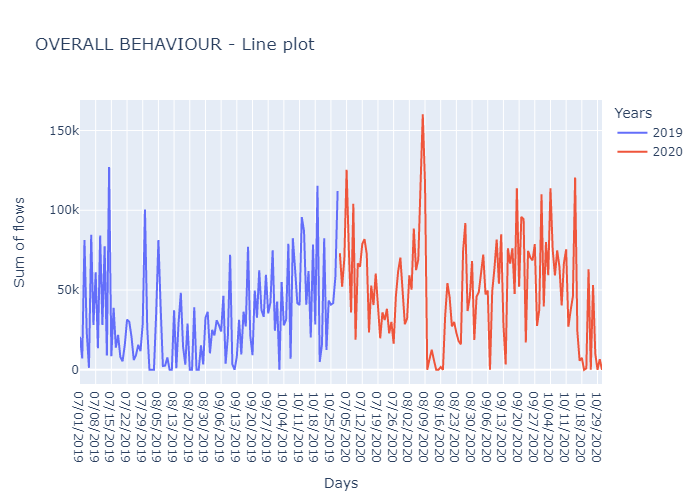

In [6]:
# Visualizzation
fig = px.line(group, x = group.index.get_level_values(1), y = group['Flow'], 
              color = group.index.get_level_values(0),
              title = 'OVERALL BEHAVIOUR - Line plot',
              labels = {'Flow' : 'Sum of flows', 'x' : 'Days', 'color' : 'Years'} # dict for labels 
             ) # Line plot

fig1 = px.histogram(group1, 
                    x =  group1.index.get_level_values(0), 
                    y =  group1['Flow'], 
                    color = group1.index.get_level_values(0), 
                    title = 'OVERALL BEHAVIOUR - Histogram',
                    labels = {'Time' : 'Years'},
                   ) # Hist

# Uncomment, if you download, for interactive plots
fig.show("png")
fig1.show("png")
# fig.show()
# fig1.show()

We have a **non-liner trends** for the sum of flows in both the periods.

Clearly, the water consumption is higher during the Pandemic (thus **smartworkers consume more water**).

Interesting peaks, above all the one during the first two weeks of August intra-pandemic.

If we look the 0 values for sum of flows we can see when the user is away from homes.

[Return to contents](#contents)

<a id = 'month'></a>
# Monthly behaviour of the water consumption before and intra the pandemic 

In [7]:
# Data manipulation
group = df.groupby([df.index.strftime('%Y/%m'), df.index.strftime('%m/%d/%Y')]).sum() # For line plot
group1 = df.groupby([df.index.strftime('%Y'), df.index.strftime('%Y/%m')]).sum() # For hist 

display_side_by_side(group1.head(7), group.head(), titles=['3 Global monthly behaviour', '4 By day monthly behaviour']) 

3 Global monthly behaviour 
 
 
 
 
 Flow 
 
 
 Time 
 Time 
 
 
 
 
 
 2019 
 2019/07 
 1040577.0 
 
 
 2019/08 
 458102.0 
 
 
 2019/09 
 959555.0 
 
 
 2019/10 
 1411205.0 
 
 
 2020 
 2020/07 
 1583092.0 
 
 
 2020/08 
 1365369.0 
 
 
 2020/09 
 1797370.0 
 
 
 4 By day monthly behaviour 
 
 
 
 
 Flow 
 
 
 Time 
 Time 
 
 
 
 
 
 2019/07 
 07/01/2019 
 20690.0 
 
 
 07/02/2019 
 7152.0 
 
 
 07/03/2019 
 81401.0 
 
 
 07/04/2019 
 23660.0 
 
 
 07/05/2019 
 1232.0

In [8]:
# Visualizzation
fig = px.line(group, x = group.index.get_level_values(1), y = group['Flow'], 
              color = group.index.get_level_values(0),
              title = 'MONTHLY BEHAVIOUR - Line plot',
              labels = {'Flow' : 'Sum of flows', 'x' : 'Days', 'color' : 'Years/Months'}
             ) # Line plot

fig1 = px.histogram(group1, 
                    x =  group1.index.get_level_values(1), 
                    y =  group1['Flow'], 
                    color = group1.index.get_level_values(1), 
                    title = 'MONTHLY BEHAVIOUR - Histogram',
                    labels = {'Flow' : 'Sum of flows', 'x' : 'Years/Months', 'color' : 'Years/Months'}
                   ) # Hist

# Uncomment, if you download, for interactive plots
fig.show("png")
fig1.show("png")
# fig.show()
# fig1.show()

**Non-liner trends** for the sum of flows within months.

August is a well-known holiday month's, in fact, within it, we have the biggest gap in water consumption between worker and smart worker(probably due to the frequent lockdowns).

From the above statement we can extend it by saying that the water consumption between workers and smart workers is closer during canonical working months i.e., autumn, winter and spring, but always higher for smartworkers.

Thus **month could be an useful feature in order to understand weather the water consumption is related to workers or smart workers**.

[Return to contents](#contents)

<a id = 'day'></a>
# Daily water consuption patterns 

In [9]:
# Data manipulation 
group = df.groupby([df.index.year, df.index.hour]).sum() # For line plot 
group1 = df.groupby([df.index.hour, df.index.year]).sum() # For Hist 

display_side_by_side(group.head(), group1.head(6), titles=['5 Daily water consumption patterns (for Line)', 
                                            ' 6 Daily water consumption patterns (for Hist)']) 

5 Daily water consumption patterns (for Line) 
 
 
 
 
 Flow 
 
 
 Time 
 Time 
 
 
 
 
 
 2019 
 0 
 56133.0 
 
 
 1 
 8417.0 
 
 
 2 
 11441.0 
 
 
 3 
 35494.0 
 
 
 4 
 6224.0 
 
 
 6 Daily water consumption patterns (for Hist) 
 
 
 
 
 Flow 
 
 
 Time 
 Time 
 
 
 
 
 
 0 
 2019 
 56133.0 
 
 
 2020 
 47453.0 
 
 
 1 
 2019 
 8417.0 
 
 
 2020 
 41340.0 
 
 
 2 
 2019 
 11441.0 
 
 
 2020 
 51480.0

In [10]:
# Plotting 
fig = px.line(group, x = group.index.get_level_values(1), y = group['Flow'], 
              color = group.index.get_level_values(0),
              title = 'DAILY WATER CONSUPTION PATTERNS - Line plot',
              labels = {'Flow' : 'Sum of flows', 'x' : 'Hours', 'color' : 'Years'}
             ) # Line plot

fig1 = px.histogram(group1, 
                    x =  group1.index.get_level_values(0), 
                    y =  group1['Flow'], 
                    color = group1.index.get_level_values(1), 
                    nbins = 46,
                    barmode = 'group',
                    title = 'DAILY WATER CONSUPTION PATTERNS - Histogram',
                    labels = {'x' : 'Hours', 'color' : 'Years'}
                   ) # Hist

# Uncomment, if you download, for interactive plots
fig.show("png")
fig1.show("png")
# fig.show()
# fig1.show()

**Non linear** daily trends for the water consumption.

Water consumption peaks for smart worker between 14:00 and 16:00.

The water consumption from workers to smart workers switch from early morning to afternoon hours (Since workers do showers, cook meals ... before going to work).

Clearly **daily hours are useful features in order to understand weather the water consumption is related to workers or smart workers**.

[Return to contents](#contents)

<a id = 'fix'></a>
# Fixtures analysis

In [11]:
# Data manipulation
group = df.groupby([df['Fixture'], df.index.strftime('%Y')]).sum()  
group1 = df.groupby([df['Fixture'], df.index.strftime('%Y/%m')]).sum() 

display_side_by_side(group, group1.head(6), titles=['Fixture analysis - Overall', 'Fixture analysis - Monthly']) 

Fixture analysis - Overall 
 
 
 
 
 Flow 
 
 
 Fixture 
 Time 
 
 
 
 
 
 Bidet 
 2019 
 380416.0 
 
 
 2020 
 398617.0 
 
 
 Kitchenfaucet 
 2019 
 802757.0 
 
 
 2020 
 1631032.0 
 
 
 Shower 
 2019 
 1876084.0 
 
 
 2020 
 2820991.0 
 
 
 Washbasin 
 2019 
 810182.0 
 
 
 2020 
 1046162.0 
 
 
 Fixture analysis - Monthly 
 
 
 
 
 Flow 
 
 
 Fixture 
 Time 
 
 
 
 
 
 Bidet 
 2019/07 
 115663.0 
 
 
 2019/08 
 32354.0 
 
 
 2019/09 
 96779.0 
 
 
 2019/10 
 135620.0 
 
 
 2020/07 
 160868.0 
 
 
 2020/08 
 89251.0

In [12]:
# Plotting 
fig = px.histogram(group, 
                    x =  group.index.get_level_values(1), 
                    y =  group['Flow'], 
                    color = group.index.get_level_values(0), 
                    barmode = 'group',
                    title = 'FIXTURES ANALYSIS - Overall',
                    labels = {'x' : 'Years', 'color' : 'Fixtures'}
                   ) 

fig1 = px.histogram(group1, 
                    x =  group1.index.get_level_values(1), 
                    y =  group1['Flow'], 
                    color = group1.index.get_level_values(0), 
                    barmode = 'group',
                    title = 'FIXTURES ANALYSIS - Monthly',
                    labels = {'x' : 'Years/Months', 'color' : 'Fixtures'}
                   ) 

# Uncomment, if you download, for interactive plots
fig.show("png")
fig1.show("png")
# fig.show()
# fig1.show()

**Bidet** shows no evident differencies among Pre and intra pandemic.

**Kitchenfaucet** water consumptions, from worker to smart worker, significally increases(smart worker cooks their meals at home).

**Shower** water consumptions, from worker to smart worker, increases. Notice the peak in intra-Pandemic August(2020/08), the summer heat leads smartworker to take frequent showers at home. Vicersa, workers during August(2019/08), probably go on holiday thus the shower water consumptions drastically decreases.

**Washbasin** water consumptions, from worker to smart worker, increases (cleaning hands before meals, fill water bottles, ...).

Overall **Fixtures are useful features in order to understand weather the water consumption is related to workers or smart workers**.

[Return to contents](#contents)

<a id = 'class'></a>
# A supervised learning problem

Supervised learning algorithms are employed when the **training data has output variables corresponding to the input variables.**

The algorithm analyses the input data and learns a function to map the relationship between the input and output variables.

Supervised learning can be classified mainly into regression and **classification**.

Suppose that a company is interested to discover if its employees was on smart or normal working in the past days.

Throught our water consumption `dataframe` we can train a supervised classification model to solve the task.

Since our training data have categorical output variables _(Years: 2019 worker, 2020 smart worker)_ corresponding to the input variables, this is clearly a **supervised learning problem** of **classification**.

<a id = 'pre'></a>
# Preprocessing 

<a id = 'new'></a>
## New working dataframe 

In [13]:
df_super = df.copy()
df_super['Month'] = df_super.index.strftime("%B") # .strftime("%B"): Extract from a datetime the months as strings
df_super['Day'] = df_super.index.strftime("%A") # .strftime("%A"): Extract from a datetime the days as strings
df_super['Worker'] = np.where(df_super.index.year == 2020, 1, 0)
df_super.reset_index(drop = True, inplace = True) # inplace datetime index 
df_super = df_super.groupby([df_super['Month'], df_super['Day'], df_super['Fixture'], df_super['Worker']], as_index = False).sum()
df_super

,Month,Day,Fixture,Worker,Flow
0,August,Friday,Bidet,0,7411.0
1,August,Friday,Bidet,1,10327.0
2,August,Friday,Kitchenfaucet,0,24179.0
3,August,Friday,Kitchenfaucet,1,65748.0
4,August,Friday,Shower,0,44753.0
...,...,...,...,...,...
219,September,Wednesday,Kitchenfaucet,1,46128.0
220,September,Wednesday,Shower,0,74448.0
221,September,Wednesday,Shower,1,197153.0
222,September,Wednesday,Washbasin,0,29646.0


To predict by daily water measurement the workers behaviour I consider as predictors ( **X** `input variables`):

- **Flow**: daily sum of flows.


- **Month** of the correspondent **Flow**.


- **Fixture** of the correspondent **Flow**.


By looking exploratory plots, I don't consider **Day** since those aren't meaningful for determine smart or normal workers (will reduce model **accuracy**/ dropped in **pipeline**).

**Day** used only in `groupby` for generate daily sum of flows.

**Worker** will be our **Y** `output variables`:


- **0** normal workers.


- **1** smart workers.

In classification field we need to **bin** continuos variables(Flow).

In [14]:
df_super['Flow'] = pd.qcut(df_super['Flow'], q = 10, duplicates = 'drop') # Binning by decile
df_super.head()

,Month,Day,Fixture,Worker,Flow
0,August,Friday,Bidet,0,"(66.999, 8348.4]"
1,August,Friday,Bidet,1,"(8348.4, 13440.2]"
2,August,Friday,Kitchenfaucet,0,"(18289.4, 24180.2]"
3,August,Friday,Kitchenfaucet,1,"(53747.8, 68376.4]"
4,August,Friday,Shower,0,"(41667.2, 53747.8]"


In [15]:
df_super

,Month,Day,Fixture,Worker,Flow
0,August,Friday,Bidet,0,"(66.999, 8348.4]"
1,August,Friday,Bidet,1,"(8348.4, 13440.2]"
2,August,Friday,Kitchenfaucet,0,"(18289.4, 24180.2]"
3,August,Friday,Kitchenfaucet,1,"(53747.8, 68376.4]"
4,August,Friday,Shower,0,"(41667.2, 53747.8]"
...,...,...,...,...,...
219,September,Wednesday,Kitchenfaucet,1,"(41667.2, 53747.8]"
220,September,Wednesday,Shower,0,"(68376.4, 93713.2]"
221,September,Wednesday,Shower,1,"(93713.2, 197153.0]"
222,September,Wednesday,Washbasin,0,"(24180.2, 31333.0]"


Not to many (**overfitting**) or viceversa (**underfitting**), **decile** are a fair trade-off.

[Return to contents](#contents)

<a id = 'pip'></a>
# Pipeline

`Pipeline` assemble several steps to apply on data for improve ML models.

Classification algorithms works better with discrete numeric values.

In [16]:
# Required tools
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder


pipeline = Pipeline(steps = [("ordinal_encoder", OrdinalEncoder()), ("cat_encoder", OneHotEncoder(sparse=False))]) 
# "ordinal_encoder", "cat_encoder" encoders id's/Names  
# sparse = False for array return

attribs = ['Month', 'Fixture', 'Flow'] # Object varibles, 'Day' not specyfied, dropped by default 

preprocess_pipeline = ColumnTransformer(transformers = [("cat", pipeline, attribs)]) 

`OrdinalEncoder` maps categorical values with discrete integer values.

`OneHotEncoder` creates boolean columns for each class(OrdinalEncoder integers) of each categorical variable. 

`ColumnTransformer` applies transformers (triplets: Name, Object, Columns) to columns of a pandas DataFrame.

In [17]:
# Splitting input X and output Y variables 
X = df_super.drop('Worker', axis = 1)
Y = df_super['Worker']

In [18]:
# Pipeline application 
X = preprocess_pipeline.fit_transform(X)

# Directly on input var. since we will generate many random training set

[Return to contents](#contents)

<a id = 'svm'></a>
# Support Vector Machine SVM

Supervised machine learning algorithm used for both **classification** or regression.

Plots each observation _(water measuraments)_ as point in p-dimensional space _(p features: Month, Day, Flow)_ where values of each feature will be values of particular coordinates(so called, Support Vectors).

Performs classification by finding the hyper-plane in the p-dimensional space that best differentiates classes _(2, Workers)_ for the observations. 

(In case of multiclass classification it breaks down the multiclassification problem into multiple binary classification(as OneHotEncoders))

<a id = 'why'></a>
# Why SVM?

1. **Size of the training data** small, SVM suggested.


2. **Accuracy and/or Interpretability** trade-off state, accuracy is our goal, SVMs prioritize accuracy.


3. **Speed/Training time**: Higher accuracy means higher training time, small training data size means lower training time, SVM fits the desidered properties.


**Accuracy** : number of correctly predicted data points out of all the data points.

`train_test_split` splits arrays into random train and test subsets.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2) # test_size = 0.2 --> 80% train, 20% test
X_train.shape

(179, 18)

Small size of the training data.

[Return to contents](#contents)

<a id = 'tun'></a>
# Tuning 

Parameters:

- **kernel**: function that takes low dimensional input spaces and transforms it to higher dimensional spaces. Converts not separable to separable problems by data transformations for find out which process is able to separate our data based on our defined labels/ outputs. Defines the shape of the hyperplane(Linear **/** non). Optimizes linear (`linear`) **/** non-linear(`rbf`, `poly`, `sigmoid`) separation problem depending on the option choices. Options: `linear`, `rbf`, `poly`, `sigmoid`.


- **gamma**: Kernel coefficient for non linear hyperplanes. With higher gamma values it tries to exactly fit the training data set, care for **overfitting**, looking for the **trade-off**.


- **C** penalty parameter of the error term. Controls the trade-off between smooth decision boundary and classifying the training points correctly. Increasing C values may prone to **overfitting** training data.


- **degree**: used only when kernel = `poly`(ignored otherwise). Degree of the polynomial used to find the hyperplane (higher degrees, higher training time)

In [20]:
# Loop setup

# For pretty load bar (since long loop)
from tqdm import tqdm

# SVM tools
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score

# Options
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
gammas = [0.1, 1, 10, 100, 'auto' ,'scale'] # floats, 'scale' = 1 / (n_features * X.var()), ‘auto’ = 1 / n_features.
cs = [0.1, 1, 10, 100, 1000] # strictly positive float values
# degrees = [0, 1, 2, 3, 4, 5, 6] if tune also those training time drastically increases, I leave only the default one
#                                 degree = 3

score = []
param = []

In [21]:
# Loop
with tqdm(total = len(kernels)* len(gammas)* len(cs)) as pbar: 
    # total = overall loop iterations
    for kernel in kernels:
        for gamma in gammas:
            for c in cs:
                svc = svm.SVC(kernel = kernel, gamma = gamma, C = c)
                single_score = cross_val_score(svc, X, Y, cv = 10, scoring = 'accuracy')
                score.append(single_score.mean())
                param.append([kernel, gamma, c])
                pbar.update(1)
                # update the bar for each single iteration

100%|██████████| 120/120 [00:06<00:00, 18.14it/s]


`sklearn.svm.SVC` defines our Support Vector Classification model.

### I tune parameters exploiting cross_validation procedures by choosing those that maximize the model skill on new data.

Good Models are those which give good predictions on new data and avoid **overfitting** and **underfitting**.

**Cross validation** procedure is used to avoid overfitting and evaluate skills of models on new data.

**Overfitting**: ML models capture also noises from the data i.e., fit the data too well. Results in good training accuracy but poor results on new data(Testing).

**Underfitting**: ML models cannot capture the trend of the data i.e, do not fit the data well enough. Results of too simple models.

`cross_val_score` evaluate a score _(`scoring` = 'accuracy')_ of an `estimator` (object used to fit the data: _(SVC)_ ) by cross-validation. `cv` sets the number of folds(k).

For knowing how well our model will perform on new data we split our dataset into separate training and test subsets, **K-Fold Cross Validation** adempt this task.

Has a single parameter **k(fold)** number of groups that a given data sample is to be split into.

**Steps** (performed by `cross_val_score`):

    1. 1 group as test data set
    
    2. remaining groups as a training data set
    
    3. Fit a model on the training set and evaluate it on the test set
    
    4. Retain the evaluation score and discard the model
    
    5. Repeat until each group has been the test one

    6. At the end Summarize the skill of the model (cross_val_score.mean).

k is chosen such that each train/test group is large enough to be statistically representative. **k=10** is a very common trade-off.

_Cross validation retrive relaiable model skill on new data, since the "new data" changes iteratively during the procedure depending on k param._

_Due to the amount of different "testing" avoid also overfitting._

In [22]:
best_par = param[score.index(max(score))] # Saving best parameter for the model
print('Best param:', param[score.index(max(score))])

Best param: ['rbf', 'scale', 10]


Best accuracy: 0.6365612648221344 at index: 57


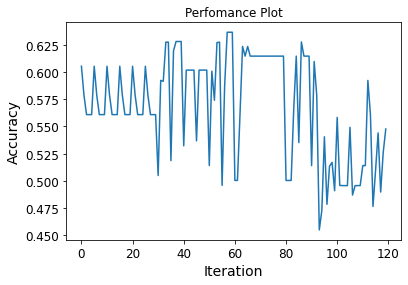

In [23]:
# Accuracy trend 
best_acc = max(score) # Saving best accuracy for comparisons
print('Best accuracy:', best_acc,'at index:', score.index(best_acc))
plt.plot(range(len(score)), score)  
plt.xlabel('Iteration')
plt.ylabel('Accuracy') 
plt.title('Perfomance Plot')
plt.show()

[Return to contents](#contents)

<a id = 'bag'></a>
# Bagging

Bagging is an **Ensemble Learning technique**.

Ensemble techniques use multiple learning algorithms on different datasets to obtain better predictive performance and realiable results.

In **Bagging** same models are trained on different dataset i.e., different train **/** test from the origial one _(bootstrapping: random sampling with replacement)_.

At classification step, each model will vote on the prediction outcome and the overall output will be the class that has received  most votes.

In [24]:
# Bootstrapping and Training 

mod = []

# 100 bagging size
for i in range(100):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
    mod.append(svm.SVC(kernel = best_par[0], gamma = best_par[1], C = best_par[2]).fit(X_train, Y_train))    

`train_test_split` within loop for different datasets train **/** test since generation is random.

`svm.SVC().fit(X_train, Y_train)` training step.

List **mod** will contains 100 models trained on different dataset.

In [25]:
# Single accuracy evaluations

scores = []
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2) # this train and test split will be
                                                                           # used also in the next step
for m in mod: 
    score = m.score(X_test, Y_test)
    scores.append(score)

List **scores** will contains the scoring of models that I will use as weights during the voting phase for the overall output.


`.score(X_test, Y_test)` makes predictions using X_test and uses those predictions with Y_test to evaluate the accuracy of the model.


`svm.SVC().predict(X_test)` Classification step, prediction outcome.

In [26]:
# Classification steps, prediction outcome, voting phase

# For boundary votes
import random 
l = [0, 1]

pred1 = [] # Final predictions list
correct = 0 # Correct predictions with respect to Y_test


for x, y in zip(X_test, Y_test): 
    # X_test, Y_test defined in previous step
    count0 = 0
    count1 = 0
    # count0 count the 0 predictions (Normal workers), count1 vicerversa Smart Workers
    
    # Summing and weighting votes
    for m, s in zip(mod, scores):
        pred = m.predict(x.reshape(1, -1)) # .reshape(1, -1) since we are predicting on single sample dataset
                                           # (otherwis doesn't works)
        if pred == 1:
            count1 += 1 * s 
        if pred == 0:
            count0 += 1 * s
            # s = weigthing accuracy score
    
    # Voting phase 
    if count1 > count0:
        pred1.append(1)
    if count1 < count0:
        pred1.append(0)
    if count1 == count0:
        pred1.append(random.choice(l))
        # boundary decisions
    
    # Checking respect to Y_test
    if pred1[-1] == y:
        correct += 1

In [27]:
# Manually accuracy evaluation with bagging
bag_acc = correct/len(Y_test)

print('Accuracy without bagging:', best_acc)
print('Accuracy with bagging:', bag_acc)

Accuracy without bagging: 0.6365612648221344
Accuracy with bagging: 0.7555555555555555


**Bagging technique drastically increase our accuracy** due to the powerful union of different models (Classification/voting phase) trained on different dataset (Bootstrapping).

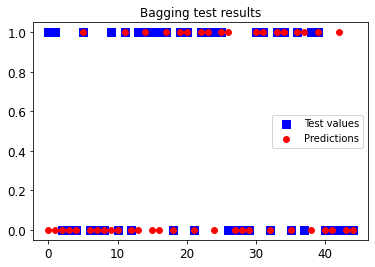

In [28]:
# Graphical rappresentation of the bagging test results

x = range(len(Y_test)) # Measuraments indexes
y_pred = pred1 # Our predictions
y_test = list(Y_test) # Test values

fig = plt.figure() # Create new figure
ax1 = fig.add_subplot(111) # 111 --> subplot location

# Adding multiple object in the the same subplot
ax1.scatter(x, y_test, s=50, c='b', marker="s", label= 'Test values')
ax1.scatter(x, y_pred, s=35, c='r', marker="o", label = 'Predictions')
plt.title('Bagging test results')
plt.legend()
plt.show()

When a red circle point overlap a blu squared one our prediction is correct.

[Return to contents](#contents)

<a id = 'real'></a>
# Real case application

Suppose now that our company wants to know where one of its employees worked in the past 3 days.

In [29]:
x_real = X[3:6] 
x_real

array([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0.]])

Suppose also that the above array x_real contains already the 3 pre-processed(with our pipeline) correspondent water measuraments of the employee.

In [30]:
solutions = Y[3:6] # Saving classification solutions for comparison

# Model usage 

Lets implement `x_real` in our bagging classifier.

In [31]:
y = [] # Our results

for x in x_real:
    count0 = 0
    count1 = 0
    for m, s in zip(mod, scores):
        pred = m.predict(x.reshape(1, -1))
        if pred == 1:
            count1 += 1 * s
        if pred == 0:
            count0 += 1 * s
    if count1 > count0:
        y.append(1)
    if count1 < count0:
        y.append(0)
    if count1 == count0:
        y.append(random.choice(l))

In [32]:
# interpreter --> see user defined functions in the setup notebook

print('Model output:', interpreter(y))
print('Real solutions:', interpreter(solutions))

Model output: ['Smartworker', 'Worker', 'Smartworker']
Real solutions: ['Smartworker', 'Worker', 'Smartworker']


[Return to contents](#contents)

<a id = 'end'></a>
# Conclusion 

During the exploratory analysis I have discover water consumption patterns of user's behaviour for fixtures, daily, monthly and among years pre and within Covid19, focusing mainly on the distinctions between workers and smartworkers as benchmarks.

In the second part, I asked myself a Machine learning problem and I try to solve it as best as I could.

[Return to contents](#contents)